<a href="https://colab.research.google.com/github/rolozanod/mexico_fuel_guided_project/blob/main/Sessions/ColabSession1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 1: Initial setup

1. Retrieve project data from GitHub
  1. Sessions notebooks
  1. Fuel consumption, census and refineries data
1. Download Mexico´s location coordinates from INEGI
1. Download fuel price data
1. Manipulate the data
  1. Calculate daily fuel consumption
  1. Calculate daily fuel prices
  1. Estimate fuel consumption for missing states and estimate seasonality from prices
1. Filter and group the important locations by revenue to reduce complexity 
1. Merge all data into a dataframe

# Clone data form the GitHub project

In [1]:
!git clone https://github.com/rolozanod/mexico_fuel_guided_project.git

Cloning into 'mexico_fuel_guided_project'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 50 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.


Install required dependencies that are not by default in Google Colab

# Unzip files from data.zip
This folder was downloaded from the GitHub repository

In [5]:
 !unzip /content/mexico_fuel_guided_project/data.zip -d /content/mexico_fuel_guided_project

Archive:  /content/mexico_fuel_guided_project/data.zip
  inflating: /content/mexico_fuel_guided_project/capacity.csv  
  inflating: /content/mexico_fuel_guided_project/demand.csv  
  inflating: /content/mexico_fuel_guided_project/short_censo2020.csv  


Change directory

In [1]:
import os
os.chdir('/content/mexico_fuel_guided_project')
os.getcwd()

'/content/mexico_fuel_guided_project'

In [2]:
!ls

README.md  capacity.csv  data.zip    geoinfo.csv  scenarios
Sessions   cpts		 demand.csv  modules	  short_censo2020.csv


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from modules.sessions import ProjectSessions as sess

In [5]:
coords = sess().get_coords()

/content/mexico_fuel_guided_project/modules/data.py:62: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/content/mexico_fuel_guided_project/modules/data.py:72: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/content/mexico_fuel_guided_project/modules/data.py:73: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/content/mexico_fuel_guided_project/modules/data.py:62: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/content/mexico_fuel_guided_

# All done with setting up the environment, see you on the next video where we will shape the data into the desired model

# Session 2: Understanding the data

1. Manipulate the data
  1. Calculate daily fuel consumption
  1. Calculate daily fuel prices
  1. Estimate fuel consumption for missing states and estimate seasonality from prices
1. Filter and group the important locations by revenue to reduce complexity 
1. Merge all data into a dataframe

In [ ]:
!pip install geopandas

### Calculate daily fuel consumption

Originally, fuel consumption is given daily per state.

The intention is to calculate this consumption by location using the `fuel consumption per capita`

* Fuel consumption: State-Day -> Location-Day
    * Given data:
        * Fuel consumption: State - Day
        * Population: Location
    1. Estimate fuel consumption per capita in the state
  $fpc = \textrm{fuel in state} / \textrm{people in state}$
    1. Map the state's cunsumption per capita into the locations
  $fpl = fpc \cdot \textrm{people in location}$

In [6]:
sess().get_pop().sample(5)

,state_key,state,loc_key,loc,pop,hab_houses,cars_per_house
1304,28,Tamaulipas,43,Xicoténcatl,11442.468214,3608.671450,1957.295980
666,16,Michoacán de Ocampo,21,Charapan,16165.659435,4084.761069,789.090323
738,16,Michoacán de Ocampo,99,Tuzantla,4161.665762,1165.078910,509.412740
1138,21,Puebla,217,Zoquitlán,11901.814684,2767.569253,178.843226
1330,29,Tlaxcala,29,Tepeyanco,7953.215812,1936.550602,872.606705


In [7]:
sess().get_demand().sample(5)

,state,year,MBBL,BBL
22,Chiapas,2019,15.946500,15946.500
129,Sonora,2021,25.611367,25611.367
125,Sonora,2017,23.674567,23674.567
0,Aguascalientes,2017,11.356853,11356.853
150,Yucatán,2017,29.342761,29342.761


In [8]:
sess().calc_fpc(sess().get_pop(), sess().get_demand(), regress = False).describe()

,state_key,loc_key,pop,hab_houses,cars_per_house,LOC_FUEL
count,1660.000000,1660.000000,1.660000e+03,1660.000000,1660.000000,1592.000000
mean,18.893373,75.259036,7.591206e+04,21224.977108,9843.848193,538.066345
std,8.025957,95.435282,2.035241e+05,57989.917161,31379.517604,1592.780941
min,1.000000,1.000000,2.688671e+03,733.204322,0.000000,13.176932
25%,13.000000,18.000000,7.901966e+03,2113.577629,547.667818,46.037867
50%,19.000000,46.000000,1.683675e+04,4543.320848,1412.262757,101.113781
75%,26.000000,93.000000,4.717999e+04,12596.816371,4462.123439,289.838634
max,32.000000,570.000000,2.262869e+06,625166.729645,391729.063868,22050.490865


### Calculate daily fuel price

There are four sources of information for fuel price:
1. Daily national price average for each fuel type (diesel, reguular, premium)
1. Monthly state price for diesel
1. Monthly state price for regular
1. Monthly state price for premium

The intention is to calculate this price by location using the by coupling the avearges to solve for fuel price

* Fuel price: National-Day -> Location-Day
    * Given data:
        * Fuel price: National - Day
        * Fuel price: State - Month
    1. Extend the State-Month price into State-Day price using the daily info from Nation-Day data
    1. Map location coordinates into gas stations and groupby location
    1. Map monthly-daily data into location-daily data using the mapped location-station data

In [9]:
sess().get_price_dataframe()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,state,price
0,2017-01-01,Aguascalientes,17.162569
1,2017-01-01,Baja California,17.068158
2,2017-01-01,Baja California Sur,17.074159
3,2017-01-01,Campeche,16.626283
4,2017-01-01,Chiapas,16.827494
...,...,...,...
48635,2021-02-28,Tamaulipas,18.224781
48636,2021-02-28,Tlaxcala,19.576055
48637,2021-02-28,Veracruz de Ignacio de la Llave,19.635799
48638,2021-02-28,Yucatán,20.375743


### Reduce complexity

The dataset will be aggregated to reduce the complexity of the optimization.

Calculate the treshhold of relevant locations given the share of revenue per state

This is done using the Box and Whisker methodology -> Q(50) + 1.5 x (Q(75) - Q(25))

This is cliped over the 10% and 90% range so no locations are found under 10% revenue and locations above 90% are not grouped

Relevant locations will mantain their name
Non-relevant locations will be named with the name state and the number of locations aggregated
* State (\# locations)

In [10]:
df = sess().create_fuel_dataframe(min_share=0.1, keep_above=0.9)

Score: 0.8760367581634618


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



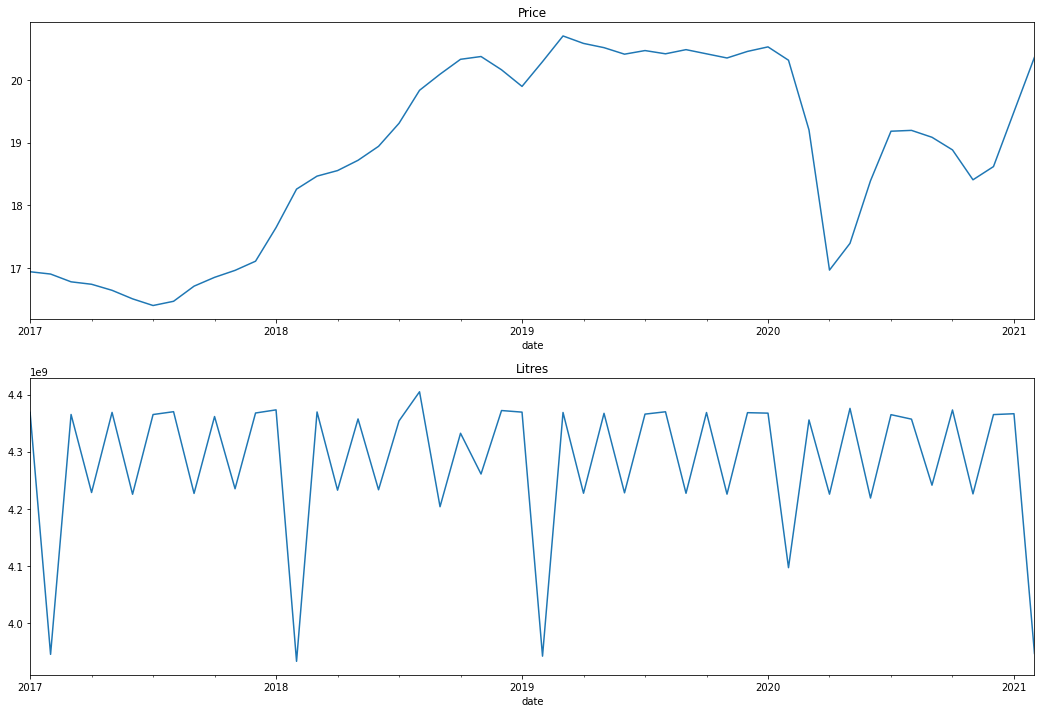

In [11]:
sess().plot_monthly_data(df)

# All done with working with the dataset, see you on the next video where we will fit the machine learning model

In [12]:
del df, coords

# Session 3 Building the stochastic model

1. Create the WindowGenerator object with reduced complexity
1. Create the VAE models for price and litres
1. Backtest the fitted models
1. Generate random samples

# Create a window generator object
This object is a variation from this __[Tensorflow Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)__

It is a deep dive into multiple approaches to predict timeseries

In [13]:
BATCH_SIZE = 16 # number of windows per batch
FORECAST_WINDOW = 1 # days to forecast
HINGESIGHT_WINDOW = 7*8+1 # days used for prediction
# WARNING! The model implemented in this project is designed for a window of 56+1

w = sess().WindowGenerator(input_width=HINGESIGHT_WINDOW, label_width=FORECAST_WINDOW, batch=BATCH_SIZE, min_share=0.1, keep_above=0.9)

Score: 0.8760367581634618


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Timesteps: 1520
Locations: 88


In [14]:
w

73 

Window entry: inputs

Windows: 2
Tuples: 3
Batches: 16
Time: 57
Features: 88 

Windows: 2
Tuples: 3
Batches: 16
Time: 57
Features: 88 

Windows: 2
Tuples: 3
Batches: 16
Time: 57
Features: 6 

Window entry: targets

Windows: 2
Tuples: 2
Batches: 16
Time: 1
Features: 88 

Windows: 2
Tuples: 2
Batches: 16
Time: 1
Features: 88 



Total window size: 58
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]
Label indices: [57]
Label column name(s): MultiIndex([(                 'Aguascalientes', ...),
            (                 'Aguascalientes', ...),
            (                'Baja California', ...),
            (                'Baja California', ...),
            (            'Baja California Sur', ...),
            (                       'Campeche', ...),
            (                       'Campeche', ...),
            (                       'Campeche', ...),
            (                        'Chiapas', ...),
            (                        'Chiapas', ...),
            (                      'Chihuahua', ...),
            (                      'Chihuahua', ...),
            (                      'Chihuahua', ...),
            (               'Ciudad de Méxic

# Create the VAE models

In [15]:
FILTERS = 32 # number of filters for the convolution layers
KERNEL_SIZE = 15 # size of the convolution window (kernel)
STRIDES = 2 # number of timesteps to skip between samples
H_UNITS = 2**8 # size of the hidden neurons for prediction
LATENT_DIMS = 2**4 # size of the embedding

# vae blocks
# price
price_ts, price_encoder, price_decoder, price_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS)

# litres
litres_ts, litres_encoder, litres_decoder, litres_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS)

In [16]:
# 80 epochs ~ 10 min
sess().train(price_vae, price_ts, litres_vae, litres_ts, window=w, MAX_EPOCHS = 80)

  0%|          | 0/80 [00:04<?, ?it/s]


KeyboardInterrupt: 

# Run the backtest

Price loss: 7.0018792152404785
Litres loss: 5.087607383728027


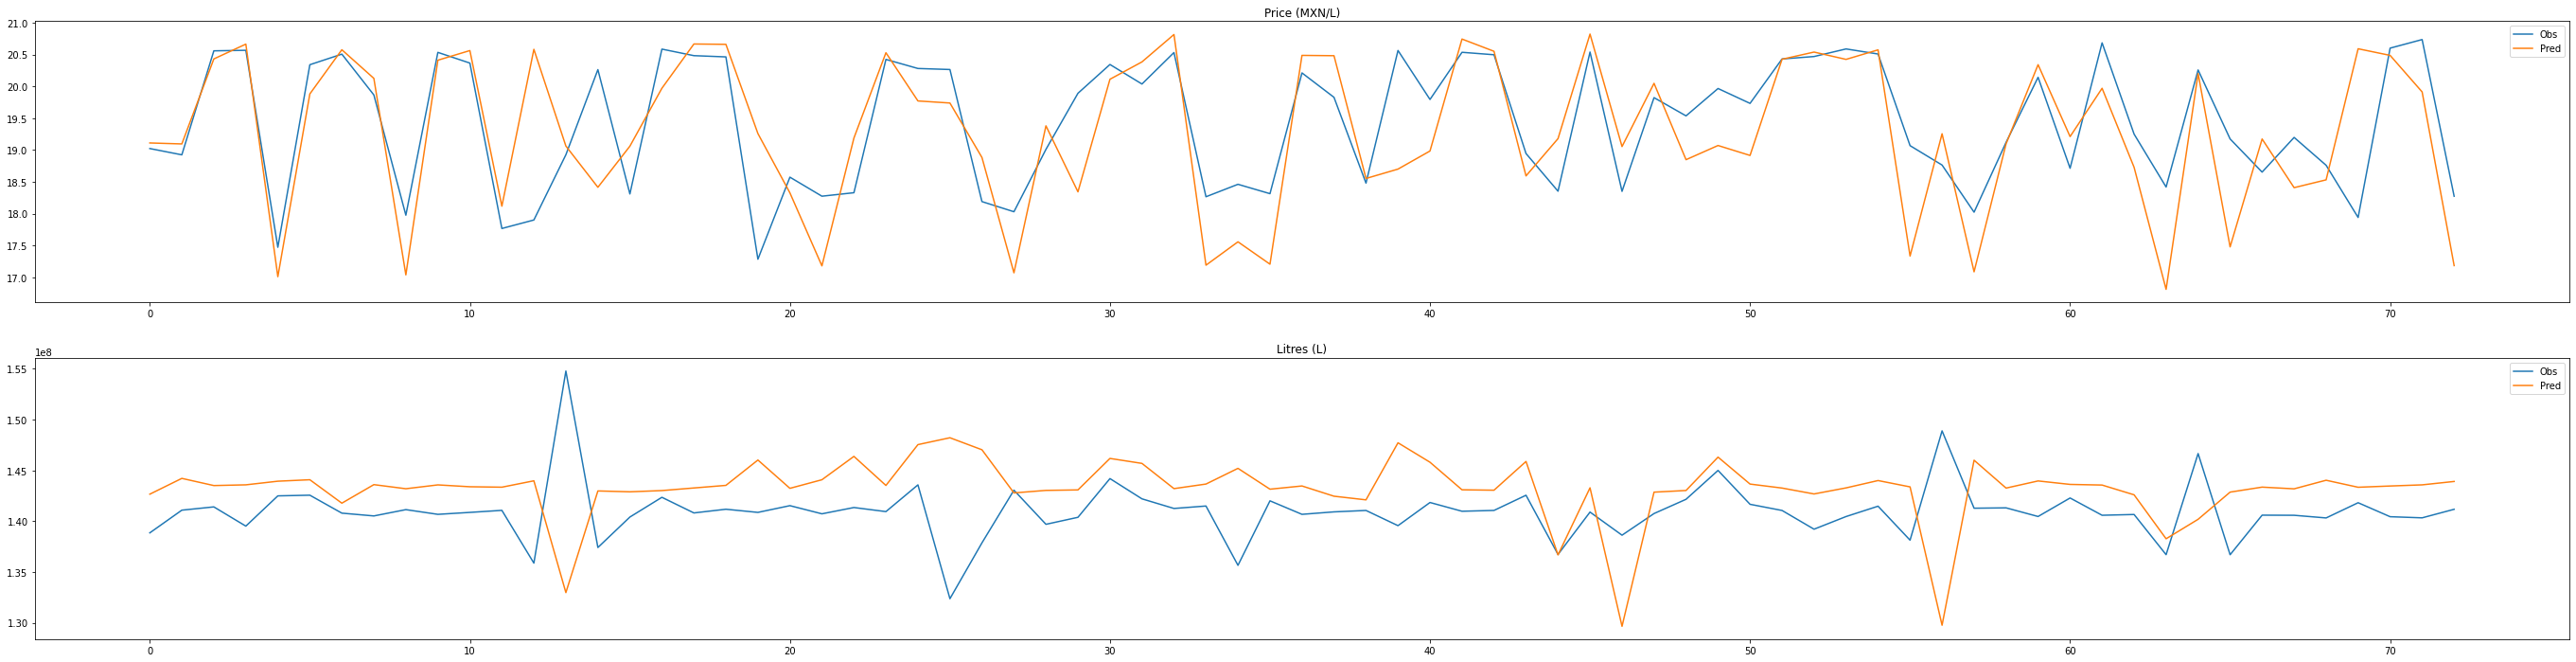

In [17]:
#sess().load_weights(0, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)
sess().run_backtest(price_vae, price_ts, litres_vae, litres_ts, window=w, plot=True)

In [ ]:
sess().save_weights(1, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

# Create and compare random samples 

Date: 2021-12-31 00:00:00: 100%|██████████| 365/365 [00:12<00:00, 28.50it/s]


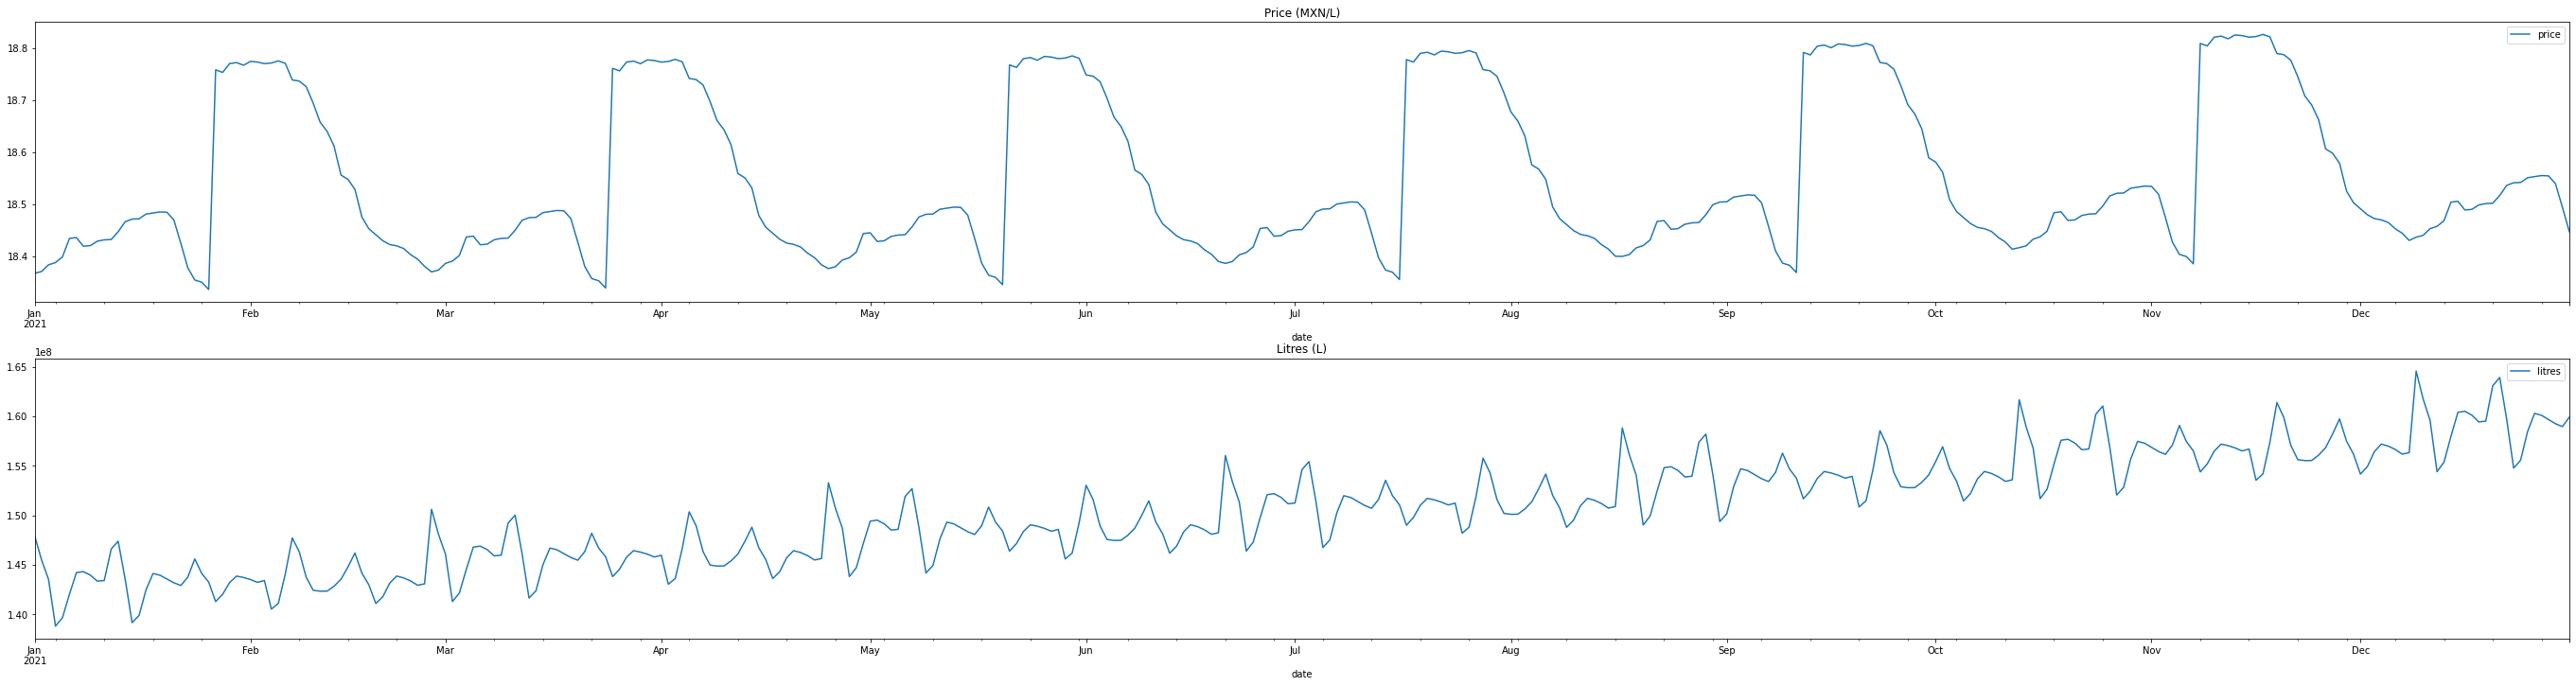

In [18]:
INIT_DATE = '2021-01-01'
FINAL_DATE = '2021-12-31'

sess().load_weights(0, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

price_ts_base, litres_ts_base = sess().forecast(price_vae, price_ts, litres_vae, litres_ts, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

Date: 2021-12-31 00:00:00: 100%|██████████| 365/365 [00:12<00:00, 28.42it/s]


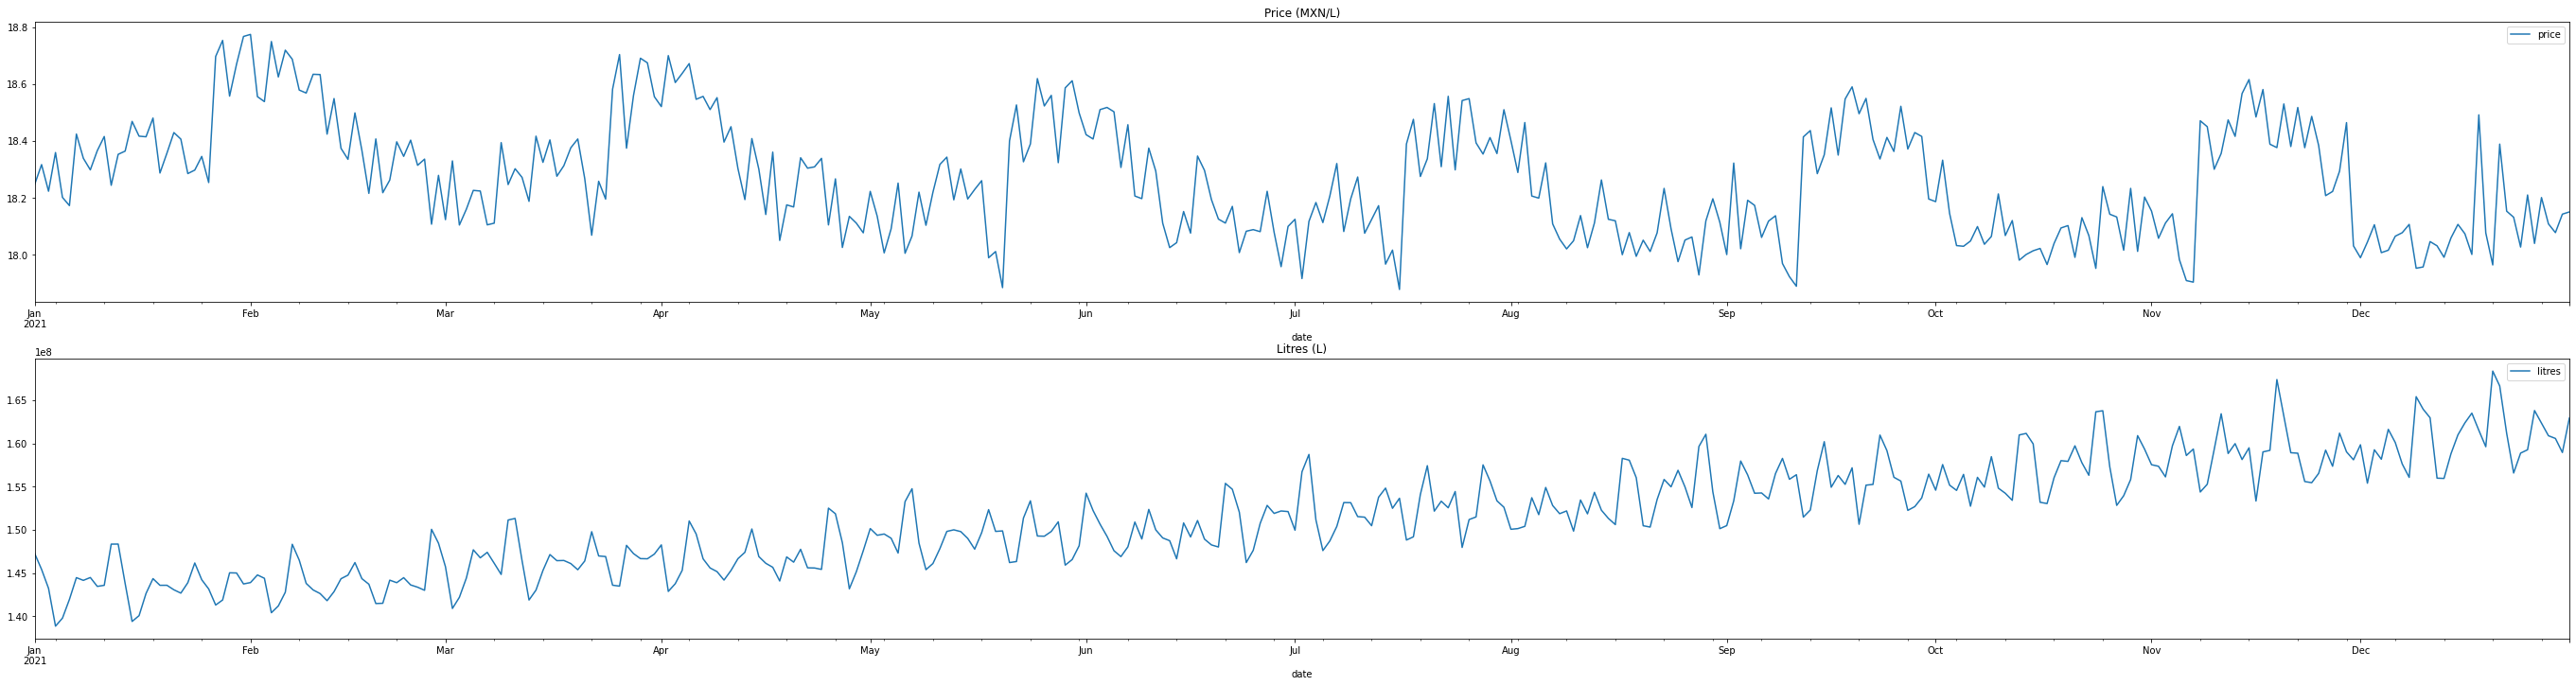

In [107]:
# vae random blocks
# price
price_ts, price_encoder, price_decoder, price_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS, random=True, amplitude=20)

# litres
litres_ts, litres_encoder, litres_decoder, litres_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS, random=True, amplitude=100)

sess().load_weights(0, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

price_ts_rand, litres_ts_rand = sess().forecast(price_vae, price_ts, litres_vae, litres_ts, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

In [20]:
print(f'Price mean average percentage variation: {100*((price_ts_base.price - price_ts_rand.price).div(price_ts_base.price)).abs().mean():.2f}%')
print(f'Volume mean average percentage variation: {100*((litres_ts_base.litres - litres_ts_rand.litres).div(litres_ts_base.litres)).abs().mean():.2f}%')

Price mean average percentage variation: 10.69%
Volume mean average percentage variation: 7.57%


# All done with creating samples using VAE, see you on the next video where we will optimize multiple scenarios

In [21]:
del price_ts_base, price_ts_rand, litres_ts_base, litres_ts_rand

# Session 4 Optimizing scenarios

1. Create scenarios according to the objectives of the projects to evaluate
1. Estimate freight rates
1. Create the production random variables
1. Create the optmization model
1. Test the optimization model
1. Initiate the optimization loop

# Get the open source optimization algorithms for GLPK

In [ ]:
!apt-get install -y -qq glpk-utils

# Import the required dependencies

In [5]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime
from tqdm.notebook import tqdm
import pyomo.environ as pme

# Create scenarios

We can create different scenarios as seen in last video.

But an optimization model that maximized on daily observations would be huge.

The model will be built to optmize monthly observations.

# Create a monthly time series

In [6]:
opt_periods = 12

INIT_DATE = '2021-01-01'
FINAL_DATE = datetime.strptime(INIT_DATE, '%Y-%m-%d') + relativedelta(months=opt_periods) - relativedelta(days=1)

BATCH_SIZE = 16 # number of windows per batch
FORECAST_WINDOW = 1 # days to forecast
HINGESIGHT_WINDOW = 7*8+1 # days used for prediction

w = sess().WindowGenerator(input_width=HINGESIGHT_WINDOW, label_width=FORECAST_WINDOW, batch=BATCH_SIZE, min_share=0.1, keep_above=0.9)

Score: 0.8760367581634618


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Timesteps: 1520
Locations: 88


In [7]:
price, demand, period_stats = sess().monthly_data(version=0, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

Date: 2021-12-31 00:00:00: 100%|██████████| 365/365 [00:14<00:00, 25.45it/s]


In [159]:
period_stats

,days,T
date,,
2021-01,31,0
2021-02,28,1
2021-03,31,2
2021-04,30,3
2021-05,31,4
2021-06,30,5
2021-07,31,6
2021-08,31,7
2021-09,30,8


In [160]:
demand.head()

,date,state,loc,T,litres
0,2021-01,Aguascalientes,Aguascalientes,0,4.187437e+07
1,2021-01,Aguascalientes,Aguascalientes_aggregate(10),0,1.405911e+07
2,2021-01,Baja California,Baja California_aggregate(5),0,9.576689e+07
3,2021-01,Baja California,Tijuana,0,1.082684e+08
4,2021-01,Baja California Sur,Baja California Sur_aggregate(5),0,4.171717e+07


# Estimate freight

The coordinates of each location are stored in the WindowGenerator object and the coordinates for the refineries are in the unzipped data, so we estimate the distance between them using the __[haversine function](https://en.wikipedia.org/wiki/Haversine_formula)__


In [8]:
distances = sess().get_distances(window=w)

In [9]:
demand.state.unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Chiapas', 'Chihuahua', 'Ciudad de México',
       'Coahuila de Zaragoza', 'Colima', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'Michoacán de Ocampo', 'Morelos',
       'México', 'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla', 'Querétaro',
       'Quintana Roo', 'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco',
       'Tamaulipas', 'Tlaxcala', 'Veracruz de Ignacio de la Llave',
       'Yucatán', 'Zacatecas'], dtype=object)

We will esteimate freight in a very simple way, having the distances we will define a cost per kilometer and we can modify specifically some locations if we want to do so be cause we have some extra information on the regions geography or highways.

In [10]:
overall_mxnxton_kms = 0.2 # MXN/(Ton-Km)
pipe_size = 20000 # (L/trip) 
fuel_weight = (0.8508+0.7489)/2/1000 # (Ton/L) = (Kg/L)/(1 Ton/1000 Kg) 0.8508 is for fuel, 0.7489 is for gasoline

### trip = 20,000 litres ###

tonsxpipe = pipe_size*fuel_weight # (Ton/trip) = (L/trip)*(Ton/L)
print(f'Ton/Pipe: {tonsxpipe}')
overall_mxnxkms = overall_mxnxton_kms*tonsxpipe # MXN/(Km-trip) = MXN/(Ton-Km)*(Ton/trip)
print(f'MXN/Km-trip: {overall_mxnxkms}')
overall_mxnxkms_L = overall_mxnxkms/pipe_size # MXN/(Km-L) = MXN/(Km-trip)/(L/trip)
print(f'MXN/Km-L: {overall_mxnxkms_L}')

freight = distances.copy()
freight['freightxkms'] = overall_mxnxkms_L
        
freight['freight'] = freight['kms']*freight['freightxkms']
print('\nFreight description:\n', freight.loc[freight.source.str.contains('Refinery')&~freight.destination.str.contains('Refinery')].freight.describe())

Ton/Pipe: 15.997
MXN/Km-trip: 3.1994000000000002
MXN/Km-L: 0.00015997

Freight description:
 count    704.000000
mean       1.854891
std        0.078239
min        1.585236
25%        1.814119
50%        1.853838
75%        1.904412
max        2.083694
Name: freight, dtype: float64


In [11]:
specific_states_rates = {
    'Baja California': 1.2, # Peninsula
    'Baja California Sur': 1.5, # Peninsula
    'Yucatán': 1.3, # Peninsula
    'Oaxaca': 1.2, # Mountain range
    'San Luis Potosí': 0.85 # Logistics hub
}

specific_state_connection_rates = {
    ('Baja California', 'Baja California Sur'): 1.3, # Mountain range
    ('Oaxaca', 'Baja California Sur'): 0.2, # Vessel
    ('Tamaulipas', 'Yucatán'): 0.2, # Vessel
    ('Veracruz de Ignacio de la Llave', 'Yucatán'): 0.2, # Vessel
}

freight = sess().fix_freight(w, freight, overall_mxnxkms_L, specific_state_connection_rates, specific_states_rates)
freight.head()

Modifying rates for specifig state connections
Modifying rates for states


,source,destination,kms,freightxkms,freight
0,Aguascalientes,Aguascalientes,0.000000,0.000160,0.000000
1,Aguascalientes,Aguascalientes_aggregate(10),9.246637,0.000160,0.001479
2,Aguascalientes,Baja California_aggregate(5),1504.807282,0.000192,0.288869
3,Aguascalientes,Tijuana,1659.159609,0.000192,0.318499
4,Aguascalientes,Baja California Sur_aggregate(5),914.986938,0.000240,0.219556


In [12]:
freight.loc[(freight.freightxkms==overall_mxnxkms_L*0.2)]

,source,destination,kms,freightxkms,freight
4804,Oaxaca de Juárez,Baja California Sur_aggregate(5),1540.029146,0.000032,0.049272
4900,Oaxaca_aggregate(159),Baja California Sur_aggregate(5),1578.129831,0.000032,0.050491
7186,Matamoros,Mérida,877.591435,0.000032,0.028078
7187,Matamoros,Yucatán_aggregate(86),929.426292,0.000032,0.029736
7282,Nuevo Laredo,Mérida,1115.524277,0.000032,0.035690
7283,Nuevo Laredo,Yucatán_aggregate(86),1167.200046,0.000032,0.037343
7378,Reynosa,Mérida,971.033739,0.000032,0.031067
7379,Reynosa,Yucatán_aggregate(86),1022.852461,0.000032,0.032725
7474,Tamaulipas_aggregate(26),Mérida,944.883590,0.000032,0.030231
7475,Tamaulipas_aggregate(26),Yucatán_aggregate(86),996.840719,0.000032,0.031893


# Create production variables

In [268]:
production = sess().get_refinery_data()
production

,state,loc,lat,lon,daily_capacity
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,1.070492e+07
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,6.433120e+06
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,6.905562e+06
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,5.849683e+06
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,6.586538e+06
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,9.122749e+06
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.000000e+00
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,3.381124e+07


# Fixed costs

In [269]:
fixed = 500000
fixed_costs_dict = {'fixed': {
    'Cadereyta Refinery': 5.0,
    'Madero Refinery': 5.0,
    'Tula Refinery': 5.0,
    'Salamanca Refinery': 5.0,
    'Minatitlan Refinery': 5.0,
    'Salina Cruz Refinery': 5.0,
    'Cangrejera Refinery': 5.0,
    'Dos Bocas Refinery': 5.0
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(fixed_costs_dict),
    left_on = 'loc',
    right_index=True
).assign(fixed=lambda r: r.daily_capacity*r.fixed*30+fixed)
production.assign(u_fixed=lambda r: r.fixed.div(r.daily_capacity*30))

,state,loc,lat,lon,daily_capacity,fixed,u_fixed
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,1.070492e+07,1.606238e+09,5.001557
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,6.433120e+06,9.654680e+08,5.002591
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,6.905562e+06,1.036334e+09,5.002414
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,5.849683e+06,8.779525e+08,5.002849
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,6.586538e+06,9.884806e+08,5.002530
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,9.122749e+06,1.368912e+09,5.001827
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.000000e+00,5.000000e+05,inf
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,3.381124e+07,5.072185e+09,5.000493


# Variable costs

In [270]:
variable = 2.0
variable_costs_dict = {'variable': {
    'Cadereyta Refinery': 0.7/1e7,
    'Madero Refinery': 0.7/1e7,
    'Tula Refinery': 0.7/1e7,
    'Salamanca Refinery': 0.7/1e7,
    'Minatitlan Refinery': 0.7/1e7,
    'Salina Cruz Refinery': 0.7/1e7,
    'Cangrejera Refinery': 0.7/1e7,
    'Dos Bocas Refinery': 0.7/1e7
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(variable_costs_dict),
    left_on = 'loc',
    right_index=True
).assign(variable=lambda r: r.daily_capacity*r.variable+variable)
production

,state,loc,lat,lon,daily_capacity,fixed,variable
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,1.070492e+07,1.606238e+09,2.749344
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,6.433120e+06,9.654680e+08,2.450318
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,6.905562e+06,1.036334e+09,2.483389
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,5.849683e+06,8.779525e+08,2.409478
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,6.586538e+06,9.884806e+08,2.461058
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,9.122749e+06,1.368912e+09,2.638592
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.000000e+00,5.000000e+05,2.000000
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,3.381124e+07,5.072185e+09,4.366786


# Storage capacity

In [271]:
storage = 500000
storage_dict = {'storage': {
    'Cadereyta Refinery': 15, # capacity in terms of production days
    'Madero Refinery': 15,
    'Tula Refinery': 15,
    'Salamanca Refinery': 15,
    'Minatitlan Refinery': 15,
    'Salina Cruz Refinery': 15,
    'Cangrejera Refinery': 15,
    'Dos Bocas Refinery': 15
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(storage_dict),
    left_on = 'loc',
    right_index=True
).assign(storage=lambda r: r.daily_capacity*r.storage+storage)
production

,state,loc,lat,lon,daily_capacity,fixed,variable,storage
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,1.070492e+07,1.606238e+09,2.749344,1.610738e+08
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,6.433120e+06,9.654680e+08,2.450318,9.699680e+07
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,6.905562e+06,1.036334e+09,2.483389,1.040834e+08
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,5.849683e+06,8.779525e+08,2.409478,8.824525e+07
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,6.586538e+06,9.884806e+08,2.461058,9.929806e+07
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,9.122749e+06,1.368912e+09,2.638592,1.373412e+08
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.000000e+00,5.000000e+05,2.000000,5.000000e+05
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,3.381124e+07,5.072185e+09,4.366786,5.076685e+08


# Safety inventories when the plant is running

In [272]:
safety_inventory = 100000
safety_inventory_dict = {'safety_inventory': {
    'Cadereyta Refinery': 1,
    'Madero Refinery': 1,
    'Tula Refinery': 1,
    'Salamanca Refinery': 1,
    'Minatitlan Refinery': 1,
    'Salina Cruz Refinery': 1,
    'Cangrejera Refinery': 1,
    'Dos Bocas Refinery': 1
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(safety_inventory_dict),
    left_on = 'loc',
    right_index=True
).assign(safety_inventory=lambda r: r.daily_capacity*r.safety_inventory+safety_inventory)
production

,state,loc,lat,lon,daily_capacity,fixed,variable,storage,safety_inventory
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,1.070492e+07,1.606238e+09,2.749344,1.610738e+08,1.080492e+07
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,6.433120e+06,9.654680e+08,2.450318,9.699680e+07,6.533120e+06
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,6.905562e+06,1.036334e+09,2.483389,1.040834e+08,7.005562e+06
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,5.849683e+06,8.779525e+08,2.409478,8.824525e+07,5.949683e+06
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,6.586538e+06,9.884806e+08,2.461058,9.929806e+07,6.686538e+06
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,9.122749e+06,1.368912e+09,2.638592,1.373412e+08,9.222749e+06
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.000000e+00,5.000000e+05,2.000000,5.000000e+05,1.000000e+05
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,3.381124e+07,5.072185e+09,4.366786,5.076685e+08,3.391124e+07


# Production time series

In [273]:
t = 0
production['T'] = t
production['days'] = period_stats.loc[period_stats['T']==t].days.values[0]
production_base = production.copy()
for t in range(1,opt_periods):
    days = period_stats.loc[period_stats['T']==t].days.values[0]
    production = pd.concat(
        [production, production_base.assign(
            T=t,
            days=days,
            fixed=lambda r: r.fixed*(1.05)**t,
            variable=lambda r: r.variable*(1.07)**t,
        )], axis = 0
    )
production.reset_index(drop=True, inplace=True)
production['capacity'] = production['daily_capacity']*production['days']
production

,state,loc,lat,lon,daily_capacity,fixed,variable,storage,safety_inventory,T,days,capacity
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,1.070492e+07,1.606238e+09,2.749344,1.610738e+08,1.080492e+07,0,365,3.907296e+09
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,6.433120e+06,9.654680e+08,2.450318,9.699680e+07,6.533120e+06,0,365,2.348089e+09
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,6.905562e+06,1.036334e+09,2.483389,1.040834e+08,7.005562e+06,0,365,2.520530e+09
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,5.849683e+06,8.779525e+08,2.409478,8.824525e+07,5.949683e+06,0,365,2.135134e+09
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,6.586538e+06,9.884806e+08,2.461058,9.929806e+07,6.686538e+06,0,365,2.404086e+09
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,9.122749e+06,1.368912e+09,2.638592,1.373412e+08,9.222749e+06,0,365,3.329803e+09
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.000000e+00,5.000000e+05,2.000000,5.000000e+05,1.000000e+05,0,365,0.000000e+00
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,3.381124e+07,5.072185e+09,4.366786,5.076685e+08,3.391124e+07,0,365,1.234110e+10
8,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,1.070492e+07,1.686550e+09,2.941798,1.610738e+08,1.080492e+07,1,365,3.907296e+09
9,Tamaulipas,Madero Refinery,22.269130,-97.810817,6.433120e+06,1.013741e+09,2.621841,9.699680e+07,6.533120e+06,1,365,2.348089e+09


# CAPEX Projects  

In [129]:
capex_projects = {'capex': {
    'Cadereyta Refinery': 0,
    'Madero Refinery': 0,
    'Tula Refinery': 0,
    'Salamanca Refinery': 0,
    'Minatitlan Refinery': 0,
    'Salina Cruz Refinery': 0,
    'Cangrejera Refinery': 0,
    'Dos Bocas Refinery': 8900*20*1e6
    }
}

capex_projects = pd.DataFrame(capex_projects)

capex_projects['type'] = 'INITIAL'
capex_projects

,capex,type
Cadereyta Refinery,0.000000e+00,INITIAL
Cangrejera Refinery,0.000000e+00,INITIAL
Dos Bocas Refinery,1.780000e+11,INITIAL
Madero Refinery,0.000000e+00,INITIAL
Minatitlan Refinery,0.000000e+00,INITIAL
Salamanca Refinery,0.000000e+00,INITIAL
Salina Cruz Refinery,0.000000e+00,INITIAL
Tula Refinery,0.000000e+00,INITIAL


In [152]:
strategic_projects = {'capex': {
    'Cadereyta Refinery': 35e9,
    'Madero Refinery': 20e9,
    'Tula Refinery': 20e9,
    'Salamanca Refinery': 15e9,
    'Minatitlan Refinery': 10e9,
    'Salina Cruz Refinery': 10e9,
    'Cangrejera Refinery': 10e9,
    'Dos Bocas Refinery': 0
    },
    'increment': {
    'Cadereyta Refinery': 1.5,
    'Madero Refinery': 1.5,
    'Tula Refinery': 1.5,
    'Salamanca Refinery': 1.5,
    'Minatitlan Refinery': 1.5,
    'Salina Cruz Refinery': 1.5,
    'Cangrejera Refinery': 1.5,
    'Dos Bocas Refinery': 0
    }
}

strategic_projects = pd.DataFrame(strategic_projects)

strategic_projects['type'] = 'STRATEGIC'
strategic_projects

,capex,increment,type
Cadereyta Refinery,3.500000e+10,1.5,STRATEGIC
Madero Refinery,2.000000e+10,1.5,STRATEGIC
Tula Refinery,2.000000e+10,1.5,STRATEGIC
Salamanca Refinery,1.500000e+10,1.5,STRATEGIC
Minatitlan Refinery,1.000000e+10,1.5,STRATEGIC
Salina Cruz Refinery,1.000000e+10,1.5,STRATEGIC
Cangrejera Refinery,1.000000e+10,1.5,STRATEGIC
Dos Bocas Refinery,0.000000e+00,0.0,STRATEGIC


In [153]:
projects = pd.concat(
    [capex_projects, strategic_projects],
    axis=0
)
projects.index.names = ['loc']

projects = projects.reset_index()
projects

,loc,capex,type,increment
0,Cadereyta Refinery,0.000000e+00,INITIAL,NaN
1,Cangrejera Refinery,0.000000e+00,INITIAL,NaN
2,Dos Bocas Refinery,1.780000e+11,INITIAL,NaN
3,Madero Refinery,0.000000e+00,INITIAL,NaN
4,Minatitlan Refinery,0.000000e+00,INITIAL,NaN
5,Salamanca Refinery,0.000000e+00,INITIAL,NaN
6,Salina Cruz Refinery,0.000000e+00,INITIAL,NaN
7,Tula Refinery,0.000000e+00,INITIAL,NaN
8,Cadereyta Refinery,3.500000e+10,STRATEGIC,1.5
9,Madero Refinery,2.000000e+10,STRATEGIC,1.5


# Quick sanity checks before optimizing

In [52]:
print(f'Capacity/Demand: {100*production.capacity.sum()/demand.litres.sum():,.2f}%')

AttributeError: 'DataFrame' object has no attribute 'litres'

In [23]:
print('Capacity/Demand: \n', 100*production.groupby(['T']).capacity.sum()/demand.groupby(['T']).litres.sum())

Capacity/Demand: 
 T
0     55.315984
1     55.120854
2     54.339068
3     54.093591
4     53.315869
5     52.816795
6     52.255139
7     51.699334
8     51.173480
9     50.487953
10    50.004250
11    49.486099
dtype: float64


In [24]:
print('Sold out costs description:\n', (production.fixed/production.capacity+production.variable).replace(np.inf, np.nan).describe())

Sold out costs description:
 count    84.000000
mean      7.731825
std       0.671485
min       7.250945
25%       7.318880
50%       7.479070
75%       7.750901
max       9.724457
dtype: float64


In [25]:
print('Highest freight locations:\n', freight.loc[freight.source.str.contains('Refinery')&~freight.destination.str.contains('Refinery')].groupby(['destination']).agg({'freight': 'min'}).sort_values(by='freight', ascending=False).head(10))
print('\nFreight description:\n', freight.loc[freight.source.str.contains('Refinery')&~freight.destination.str.contains('Refinery')].freight.describe())

Highest freight locations:
                                freight
destination                           
Oaxaca_aggregate(159)         2.214339
Oaxaca de Juárez              2.210876
Benito Juárez                 1.943941
Solidaridad                   1.940161
Quintana Roo_aggregate(9)     1.935767
Baja California_aggregate(5)  1.926408
Campeche                      1.918885
Campeche_aggregate(10)        1.918355
Carmen                        1.910395
Chiapas_aggregate(101)        1.903994

Freight description:
 count    704.000000
mean       1.903257
std        0.232759
min        0.340017
25%        1.827625
50%        1.874922
75%        1.956642
max        2.752772
Name: freight, dtype: float64


In [26]:
print('Lowest price locations:\n', price.set_index('loc').price.sort_values(ascending=True).head(10))
print('\nPrice description:\n', price.price.describe())

Lowest price locations:
 loc
Chihuahua_aggregate(31)     17.284896
Chihuahua                   17.284999
Juárez                      17.285529
Tamaulipas_aggregate(26)    17.437077
Matamoros                   17.437917
Nuevo Laredo                17.438199
Reynosa                     17.438239
Victoria                    17.438530
Matamoros                   17.509815
Nuevo Laredo                17.509901
Name: price, dtype: float64

Price description:
 count    1056.000000
mean       19.766952
std         0.943599
min        17.284896
25%        19.156328
50%        19.806509
75%        20.435190
max        21.841225
Name: price, dtype: float64


In [27]:
REFINERIES=list(production['loc'].drop_duplicates().values)
LOCATIONS=list(demand['loc'].drop_duplicates().values)

WACC = 0.1
depreciation_years=10
minimum_production_period=3

opt_timelimit=60*5
mip_tolerance=1e-4

save_path="scenarios/"
opt_version='baseline'
step=0
pbar = tqdm(range(1)) 

fuel_opt = sess().get_fuel_opt_model(opt_periods, REFINERIES, LOCATIONS, demand, price, freight, production, projects, WACC, depreciation_years, minimum_production_period, step=step, pbar=pbar)

  0%|          | 0/1 [00:00<?, ?it/s]

ERROR: Constructing component 'MARKETS' from data=None failed:
    KeyboardInterrupt:


KeyboardInterrupt: 

In [ ]:
sess().optimize_MIP_model(fuel_opt, opt_timelimit, mip_tolerance, save_path, opt_version, step, pbar)

In [227]:
demand_stats, market_stats, prod_stats, inter_facilites, objective = sess().retrieve_opt_info(fuel_opt)

In [228]:
market_stats.sales.sum()

28527413671.40478

In [229]:
prod_stats.production.sum()

28607527477.713634

In [230]:
prod_stats.loc[(slice(None), 'Dos Bocas Refinery'),:]

,,state,available,expansion,capacity,production,init_inventory,inventory,switch_cost,layoff_cost,capex,costs,revenues,ebitda,depreciation,nopat,fcf_wo_nwc,utilization
0,Dos Bocas Refinery,0.0,1.0,0.0,1.048148e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.200000e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+10,0.0
1,Dos Bocas Refinery,1.0,0.0,0.0,9.467146e+08,9.467146e+08,0.000000e+00,3.391124e+07,3.391124e+07,0.0,0.000000e+00,9.240197e+09,1.787366e+10,3.607980e+09,1.833333e+08,2.226021e+09,2.409354e+09,1.0
2,Dos Bocas Refinery,1.0,0.0,0.0,1.048148e+09,1.048148e+09,3.391124e+07,1.451752e+08,0.000000e+00,0.0,0.000000e+00,9.649225e+09,1.820206e+10,3.394774e+09,1.833333e+08,2.087436e+09,2.270770e+09,1.0
3,Dos Bocas Refinery,1.0,0.0,0.0,1.014337e+09,1.014337e+09,1.451752e+08,2.829307e+08,0.000000e+00,0.0,0.000000e+00,9.501579e+09,1.715878e+10,2.831146e+09,1.833333e+08,1.721078e+09,1.904411e+09,1.0
4,Dos Bocas Refinery,1.0,0.0,0.0,1.048148e+09,1.048148e+09,2.829307e+08,4.840216e+08,0.000000e+00,0.0,0.000000e+00,9.649225e+09,1.656435e+10,2.251615e+09,1.833333e+08,1.344383e+09,1.527716e+09,1.0
5,Dos Bocas Refinery,1.0,0.0,0.0,1.014337e+09,1.014337e+09,4.840216e+08,5.076685e+08,0.000000e+00,0.0,0.000000e+00,9.501579e+09,1.963077e+10,4.674909e+09,1.833333e+08,2.919524e+09,3.102858e+09,1.0
6,Dos Bocas Refinery,1.0,0.0,0.0,1.048148e+09,1.048148e+09,5.076685e+08,5.076685e+08,0.000000e+00,0.0,0.000000e+00,9.649225e+09,2.078474e+10,5.364885e+09,1.833333e+08,3.368008e+09,3.551342e+09,1.0
7,Dos Bocas Refinery,1.0,0.0,0.0,1.048148e+09,1.048148e+09,5.076685e+08,5.076685e+08,0.000000e+00,0.0,0.000000e+00,9.649225e+09,2.106315e+10,5.643299e+09,1.833333e+08,3.548977e+09,3.732311e+09,1.0
8,Dos Bocas Refinery,1.0,0.0,0.0,1.014337e+09,1.014337e+09,5.076685e+08,5.076685e+08,0.000000e+00,0.0,0.000000e+00,9.501579e+09,2.056872e+10,5.482667e+09,1.833333e+08,3.444567e+09,3.627900e+09,1.0
9,Dos Bocas Refinery,1.0,0.0,0.0,1.048148e+09,1.048148e+09,5.076685e+08,5.076685e+08,0.000000e+00,0.0,0.000000e+00,9.649225e+09,2.154220e+10,6.122352e+09,1.833333e+08,3.860362e+09,4.043696e+09,1.0


In [231]:
prod_stats.production.sum()

28607527477.713634

In [232]:
prod_stats.capex.sum()

23800000000.0

In [233]:
prod_stats.expansion.sum()

6.0

# Now that you know how to optimize a sinlge scenario, lets wrap those functions into a loop to iteratively solve for different scenario to make an assesment

The analysis should be done on the long term so the optimization periods will be extended to 5 years and run yearly because of computing resources restrictions

In [154]:
opt_periods = 6

INIT_DATE = '2021-01-01'
FINAL_DATE = datetime.strptime(INIT_DATE, '%Y-%m-%d') + relativedelta(months=opt_periods*12) - relativedelta(days=1)

BATCH_SIZE = 16 # number of windows per batch
FORECAST_WINDOW = 1 # days to forecast
HINGESIGHT_WINDOW = 7*8+1 # days used for prediction

w = sess().WindowGenerator(input_width=HINGESIGHT_WINDOW, label_width=FORECAST_WINDOW, batch=BATCH_SIZE, min_share=0.1, keep_above=0.9)

WACC = 0.1
depreciation_years=10
minimum_production_months=3

opt_timelimit=60*5
mip_tolerance=1e-4

save_path="scenarios/"
opt_versions=['baseline', 'optimal']
n_scenarios = 20

pbar = tqdm(range(n_scenarios))

for opt_version in opt_versions:
    if not os.path.exists(save_path+opt_version+'/demand/'):
        os.makedirs(save_path+opt_version+'/demand/')

    if not os.path.exists(save_path+opt_version+'/market/'):
        os.makedirs(save_path+opt_version+'/market/')

    if not os.path.exists(save_path+opt_version+'/production/'):
        os.makedirs(save_path+opt_version+'/production/')

    if not os.path.exists(save_path+opt_version+'/objective/'):
        os.makedirs(save_path+opt_version+'/objective/')

    if not os.path.exists(save_path+opt_version+'/ts_specs/'):
        os.makedirs(save_path+opt_version+'/ts_specs/')

for step in pbar:
        
    next_step = False

    while next_step == False:

        price, demand, period_stats = sess().annual_data(version=0, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True, p_pbar=pbar)

        freight = sess().build_freight_costs(w, overall_mxnxton_kms=0.5)

        production = sess().production_timeseries(opt_periods,
                                                 period_stats,
                                                 fixed_base=10000000*12,
                                                 fixed_ratio=1.5*12,
                                                 variable_base=1.5,
                                                 variable_ratio=3.0/1e7,
                                                 storage_base=500000,
                                                 storage_ratio=30,
                                                 safety_inventory_base=100000,
                                                 safety_inventory_ratio=5
                                                 )

        REFINERIES=list(production['loc'].drop_duplicates().values)

        LOCATIONS=list(demand['loc'].drop_duplicates().values)

        for baseline_model in [False, True]:
            
            next_model = False
            
            while next_model == False:

                fuel_opt = sess().get_fuel_opt_model(opt_periods, REFINERIES, LOCATIONS, demand, price, freight, production, projects, WACC, depreciation_years, minimum_production_months, step=step, pbar=pbar, annual=True, baseline=baseline_model)

                results, last_mip_gap = sess().optimize_MIP_model(fuel_opt, opt_timelimit, mip_tolerance, save_path, opt_version, step, pbar, verbose=False)

                if results['Solver'][0]['Termination condition'].value not in ['infeasible']:

                    opt_version = {True: 'baseline', False: 'optimal'}[baseline_model]

                    demand_stats, market_stats, prod_stats, _, objective = sess().retrieve_opt_info(fuel_opt)

                    demand_stats.index.names = ['T', 'loc']
                    demand_stats.reset_index().to_csv(save_path+opt_version+f"/demand/scenario_{step}.csv", index = False)

                    period_stats.to_csv(save_path+opt_version+f"/ts_specs/stats.csv")

                    market_stats.index.names = ['T', 'loc', 'plant']
                    market_stats.reset_index().to_csv(save_path+opt_version+f"/market/scenario_{step}.csv", index = False)

                    prod_stats.index.names = ['T', 'plant']
                    prod_stats.reset_index().to_csv(save_path+opt_version+f"/production/scenario_{step}.csv", index = False)

                    objective.assign(step=step).to_csv(save_path+opt_version+f"/objective/scenario_{step}.csv", index = False)
                    
                    next_model = True

        next_step = True

Score: 0.8760367581634618


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Timesteps: 1520
Locations: 88


  0%|          | 0/20 [00:00<?, ?it/s]

Modifying rates for specific state connections
Modifying rates for states
Solver log file: 'scenarios/optimal/LOGS/optimal_0.log'
Solver solution file: '/tmp/tmp3brnxak7.glpk.raw'
Solver problem files: ('/tmp/tmpsivk8y09.pyomo.lp',)
Solver log file: 'scenarios/optimal/LOGS/optimal_0.log'
Solver solution file: '/tmp/tmpu4a8qyxk.glpk.raw'
Solver problem files: ('/tmp/tmpd1g3h1xh.pyomo.lp',)
Modifying rates for specific state connections
Modifying rates for states
Solver log file: 'scenarios/baseline/LOGS/baseline_1.log'
Solver solution file: '/tmp/tmpojfwx5dg.glpk.raw'
Solver problem files: ('/tmp/tmploelz2fs.pyomo.lp',)
Solver log file: 'scenarios/optimal/LOGS/optimal_1.log'
Solver solution file: '/tmp/tmp6glks9pa.glpk.raw'
Solver problem files: ('/tmp/tmptgjoiv_r.pyomo.lp',)
Modifying rates for specific state connections
Modifying rates for states
Solver log file: 'scenarios/baseline/LOGS/baseline_2.log'
Solver solution file: '/tmp/tmph1rtih84.glpk.raw'
Solver problem files: ('/tmp/tmp

# All done with the scenario optimization, see you in the next video where we will analyze the results

# Session 5 Analyzing the results

1. Load the saved data
1. Plot relevant information
1. Run infernece tests

In [155]:
import matplotlib.pyplot as plt

# Load the saved scenarios

In [156]:
save_path="scenarios/"
market_stats, _, prod_stats, _, period_stats = sess().load_opt_valuation(save_path)
opt_market_stats, demand_stats, opt_prod_stats, objective, _ = sess().load_opt_info(save_path, 'optimal')

# Plot relevant information

In [158]:
sess().plot_market_consumption(opt_market_stats, demand_stats, period_stats)

In [159]:
sess().plot_objective_hist(objective)

In [160]:
sess().plot_plant_production_plan(opt_prod_stats, period_stats)

In [168]:
sess().plot_plant_performance(opt_prod_stats, period_stats)

In [169]:
sess().plot_plant_performance(prod_stats, period_stats)

# Sensitivity analysis

In [162]:
sess().sensitivity_diagram(prod_stats, period_stats, WACC)

# Simulation analysis

In [163]:
benefits, costs = sess().mc_simulation(prod_stats, period_stats, WACC)

# Real Option valuation

In [171]:
T = 1
rf = 0.08

npvs, call = sess().real_opt_valuation(prod_stats, benefits, costs, projects, rf, T)

# We are done and we have the necesary information to make some suggestions and define the next steps

# Session 6 Making the decision

1. Review the project to identify the assumptions within the results
1. Make some suggestions with the available information
1. Define the next steps to improve our suggestions

### Assumptions

1. Demand was estimated with the population of each location
1. Prices were estimated by projecting the average monthly value per state given the national daily prices
1. Capacities are approximated with the production of 2020
    1. Dos Bocas capacity was retrievd from a newspaper article
1. All costs (variable, fixed, freight) are trivial and do not represent the actual ones
1. All CAPEX costs and capacities are trivial and do not represent the actual ones
    1. Dos bocas CAPEX was retrievd from a newspaper article
1. WACC and risk free rate are trivial and do not represent the actual ones
1. Valuation horizon was defined at 5 years given computing and time resources

### Suggestions
1. According to current data and with a valutaion horizon of 5 years:
    1. Dos Bocas refinery is not profitable and should not be built
    1. 

### Next steps